In [2]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, auc

# Chicago Car Crash Analysis

## Overview 
add overview 

## Business Problem

We an advertisement company hired by the City of Chicago to create a series of safe driving Public Safety Anncouncements for young adults. 

These ads will run on social media as well as being posted near high schools and college campuses. 

In order to figure out what ads will be the most effective, we are examining the causes of accidents for two age ranges: 15-18 year olds and 18-22 year olds. Once we determine the most common causes of accidents, we will be able to tailor our ads for the city, and hopefully reduce accidents for our target group.

## Data Source 

Car crash and vehicle accident data was sourced from the [Chicago Data Portal](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d/about_data). It originates from the [City of Chicago](http://www.chicago.gov/)

Data collection began in 2015, but was only adopted by all police departments in 2017. The most recent data entry was from September 26, 2024. 

## Results

add results

# Data Import and Cleaning 

In [24]:
df_vehicles = pd.read_csv("data/Traffic_Crashes_Vehicles.csv")
df_people = pd.read_csv("data/Traffic_Crashes_People.csv")
df_crashes = pd.read_csv("data/Traffic_Crashes_Crashes.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'data/Traffic_Crashes_Vehicles.csv'

## Merge Dataframes

First we sample 300,000 crash reports, then we merge the vehicle and people involved. 

In [7]:
#Random sample of vehicles 
df_accidents = df_vehicles.sample(n=300000, random_state=42)

NameError: name 'df_vehicles' is not defined

In [8]:
df_accidents.info()

NameError: name 'df_accidents' is not defined

In [9]:
#Then we can add the crash report data 
df_accidents = df_accidents.merge(df_crashes, how="inner", on=["CRASH_RECORD_ID", "CRASH_DATE"])

NameError: name 'df_accidents' is not defined

In [10]:
df_accidents.info()

NameError: name 'df_accidents' is not defined

In [11]:
#every person and vehicle should have a match for the record ID, vehicle ID, and crash date
#This makes the dataframe larger as multiple people are involved in each accident 
df_accidents = df_accidents.merge(df_people, how="inner", on=["CRASH_RECORD_ID", "VEHICLE_ID", "CRASH_DATE"])

NameError: name 'df_accidents' is not defined

In [12]:
df_accidents.info()

NameError: name 'df_accidents' is not defined

The dataframe gets larger when merging in the people, as there are sometimes more than one person involved in an accident.  

# THIS IS FOR WORKING PURPOSES. 

# USE THIS TO IMPORT DF WITHOUT RUNNING THE CELLS ABOVE.

## Export Final

In [13]:
df_accidents.to_csv('data/Final_Data.csv')

## Read Final

In [304]:
df_accidents = pd.read_csv("data/Final_Data.csv")

/var/folders/4f/cr2zm2px70q9hrgj23zmw7_r0000gn/T/ipykernel_61942/2274169522.py:1: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,55,58,59,61,71,102,123,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents = pd.read_csv("data/Final_Data.csv")


In [305]:
#Sets all column names to lowercase
df_accidents.columns = [column.lower() for column in df_accidents.columns]

# ^^^^^ DELETE BEFORE SUBMISSION

In [306]:
#have the crash date as a datetime object. 
df_accidents['crash_date'] = pd.to_datetime(df_accidents['crash_date'], format="%m/%d/%Y %I:%M:%S %p")

df_accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324360 entries, 0 to 324359
Columns: 144 entries, unnamed: 0 to cell_phone_use
dtypes: datetime64[ns](1), float64(24), int64(9), object(110)
memory usage: 356.4+ MB


## Drop Unnessisary Columns

In [307]:
#remove columns with less than 50% of data present 
df_accidents.dropna(axis=1, thresh = int(0.5*df_accidents.shape[0]), inplace=True)

In [308]:
cols_to_drop = [
#remove unessisary id columns now the data is joined 
'vehicle_id', 'crash_record_id', 'crash_unit_id',
#drop LAT and LONG (we have location)
'latitude', 'longitude',
#...also drop streets and directions. 
'street_no', 'street_direction', 'street_name', 'travel_direction', 
#police specific 
'beat_of_occurrence', 
#everything is chicago 
'city', 'zipcode', 
#covered by MOST_SEVERE_INJURY
'injury_classification',
#many NAN
'injuries_unknown'
]

df_accidents.drop(columns=cols_to_drop, inplace=True)


In [309]:
#map the injuries to a number 

def weather_code(weather):
    """
    Codes are based on https://openweathermap.org/weather-conditions
    0 - Unknown 
    500 - Rain
    600 - Snow
    700 - 'Atmosphere' (Fog, Dust, Haze) 
    800 - Clear
    801 - Clouds 

    """
    if weather == 'CLEAR':
        return 800
    elif weather == 'CLOUDY/OVERCAST':
        return 801
    elif weather == 'RAIN':
        return 500
    elif weather == 'SNOW' or weather == 'FREEZING RAIN/DRIZZLE' or weather== 'SLEET/HAIL' or weather == 'BLOWING SNOW':
        return 600
    elif weather == 'FOG/SMOKE/HAZE' or weather == 'BLOWING SAND/SOIL/DIRT':
        return 700
    else:
        return 0
    
df_accidents['weather_condition'] = df_accidents['weather_condition'].map(weather_code)

In [310]:
#map the injuries to a number 

def injury_severity(severity):
    """
    Injuties are categorized on a scale of 0 to X
    0 - No Indication of Injury 
    1 - REPORTED, NOT EVIDENT 
    2 - NONincapacitating Injury 
    3 - incapacitating Injury 
    4 - Fatal Injury 
    """
    if severity == 'NO INDICATION OF INJURY':
        return 0
    elif severity == 'REPORTED, NOT EVIDENT':
        return 1
    elif severity == 'NONINCAPACITATING INJURY':
        return 2
    elif severity == 'INCAPACITATING INJURY':
        return 3
    elif severity == 'FATAL':
        return 4
    else:
        return 0
    

df_accidents['injury_class'] = df_accidents['most_severe_injury'].map(injury_severity)

In [311]:
#map the injuries to a number 

def crash_severity(severity):
    """
    Injuties are categorized on a scale of 0 to X
    0 - No Injury / Drive Away 
    1 - Injury and / or tow  
    """
    if severity == 'NO INJURY / DRIVE AWAY':
        return 0
    else:
        return 1
    

df_accidents['crash_type'] = df_accidents['crash_type'].map(crash_severity)

In [312]:
#drop the columns 
in_cols_to_drop = [
#remove counts of each injury 
'injuries_fatal', 'injuries_incapacitating', 'injuries_non_incapacitating',
'injuries_reported_not_evident', 'injuries_no_indication'
]

df_accidents.drop(columns=in_cols_to_drop, inplace=True)

In [313]:
count = 0
for column in df_accidents.iloc[0]:
    print(df_accidents.columns[count], ":", column, ",", df_accidents.iloc[1].iloc[count])
    count += 1

unnamed: 0 : 0 , 1
crash_date : 2022-05-24 20:23:00 , 2019-09-28 13:45:00
unit_no : 1 , 2
unit_type : DRIVER , DRIVER
make : TOYOTA , VOLKSWAGEN
model : CAMRY , JETTA
lic_plate_state : IL , IL
vehicle_year : 2018.0 , 2012.0
vehicle_defect : UNKNOWN , UNKNOWN
vehicle_type : PASSENGER , PASSENGER
vehicle_use : PERSONAL , PERSONAL
maneuver : TURNING LEFT , STRAIGHT AHEAD
occupant_cnt : 1.0 , 1.0
first_contact_point : FRONT , ROOF
posted_speed_limit : 30 , 20
traffic_control_device : STOP SIGN/FLASHER , NO CONTROLS
device_condition : FUNCTIONING PROPERLY , NO CONTROLS
weather_condition : 800 , 800
lighting_condition : DUSK , DAYLIGHT
first_crash_type : PEDALCYCLIST , SIDESWIPE OPPOSITE DIRECTION
trafficway_type : FOUR WAY , OTHER
alignment : STRAIGHT AND LEVEL , STRAIGHT AND LEVEL
roadway_surface_cond : DRY , DRY
road_defect : NO DEFECTS , UNKNOWN
report_type : ON SCENE , NOT ON SCENE (DESK REPORT)
crash_type : 1 , 0
damage : $500 OR LESS , OVER $1,500
date_police_notified : 05/24/2022 08:

In [317]:
matrix = df_accidents.corr(numeric_only=True)
print(matrix)

                    unnamed: 0   unit_no  vehicle_year  occupant_cnt  \
unnamed: 0            1.000000 -0.000147      0.000440      0.005952   
unit_no              -0.000147  1.000000     -0.007320      0.103042   
vehicle_year          0.000440 -0.007320      1.000000     -0.004234   
occupant_cnt          0.005952  0.103042     -0.004234      1.000000   
posted_speed_limit    0.001071  0.073894     -0.000297      0.029766   
weather_condition     0.004400  0.030809     -0.001856      0.034301   
crash_type           -0.000479  0.061903     -0.005193      0.090895   
num_units             0.000013  0.276457     -0.000940      0.016165   
injuries_total       -0.004392  0.112213     -0.003746      0.193060   
crash_hour            0.003331  0.040057      0.001082     -0.001259   
crash_day_of_week     0.002641  0.009996      0.001206      0.001301   
crash_month          -0.001284  0.007062     -0.003140     -0.001107   
age                  -0.002107  0.020860     -0.004818     -0.19

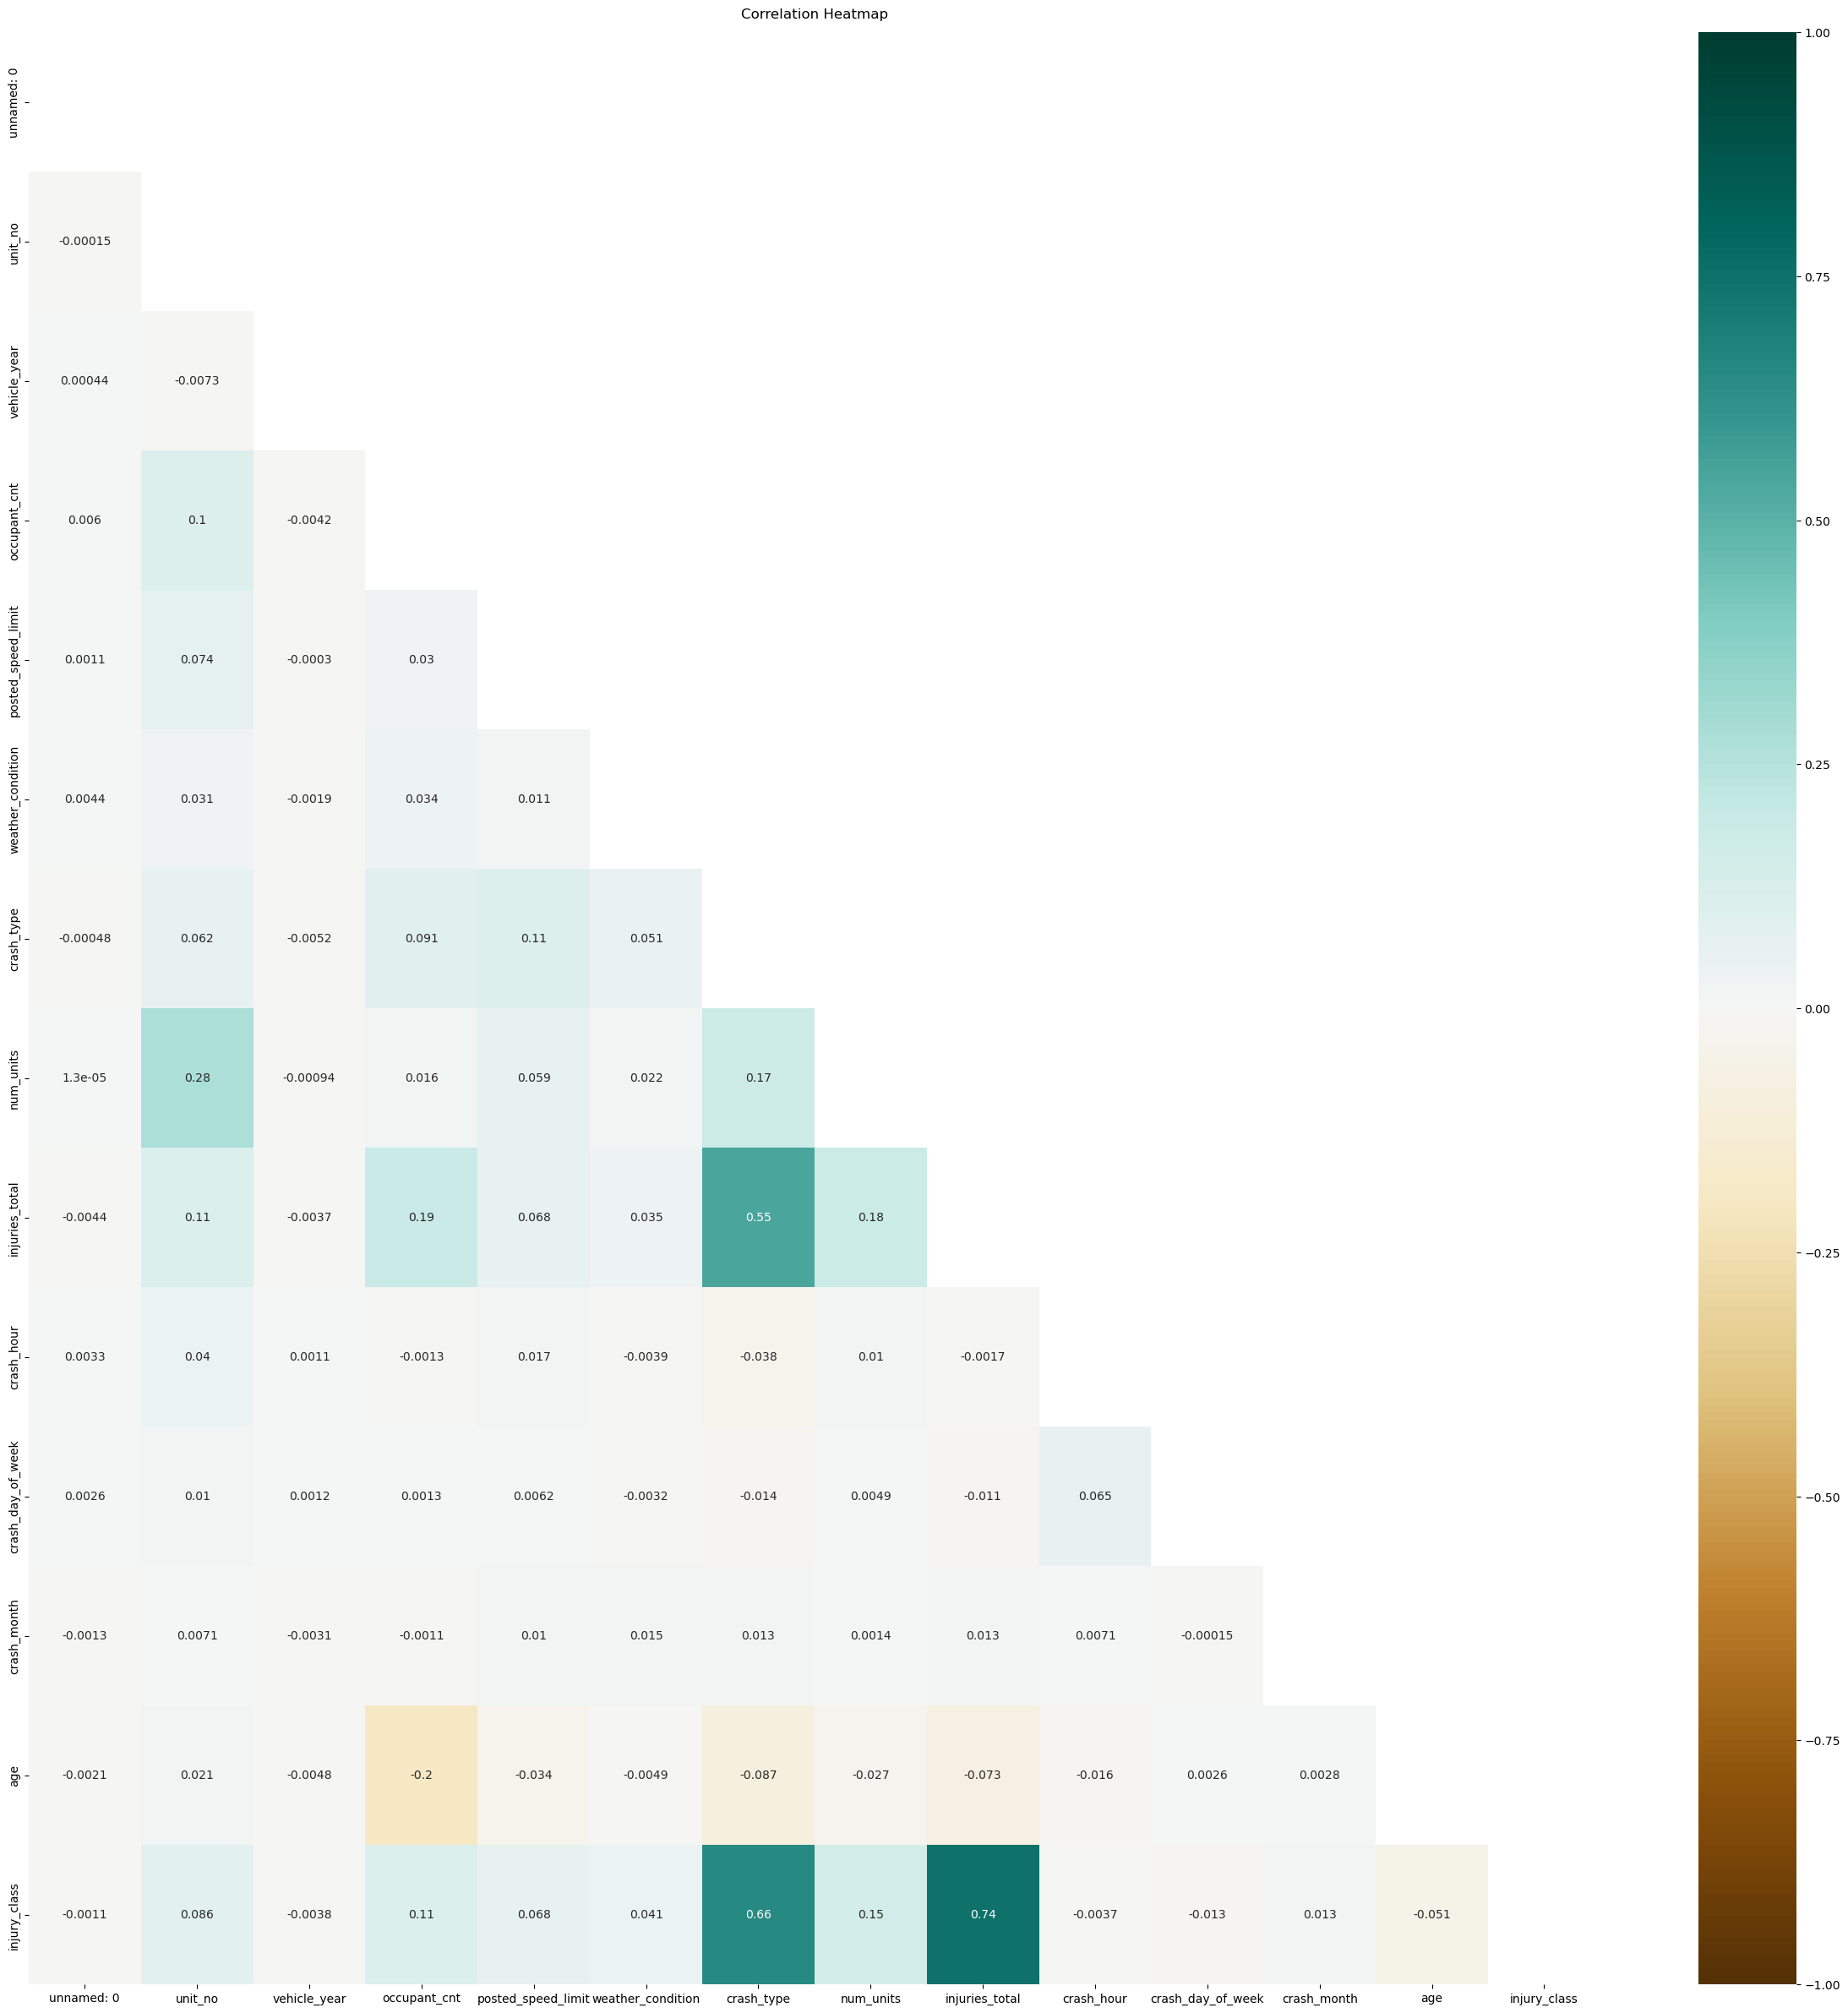

In [318]:
plt.figure(figsize=(30, 30))

#create a mask to remove the duplicate upper half
mask = np.triu(np.ones_like(matrix, dtype=np.bool))

heatmap = sns.heatmap(matrix, vmin=-1, mask=mask, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [319]:
df_accidents['prim_contributory_cause'].unique()

array(['UNABLE TO DETERMINE', 'DISREGARDING TRAFFIC SIGNALS',
       'IMPROPER LANE USAGE', 'FOLLOWING TOO CLOSELY',
       'IMPROPER TURNING/NO SIGNAL', 'IMPROPER OVERTAKING/PASSING',
       'FAILING TO YIELD RIGHT-OF-WAY',
       'DISREGARDING OTHER TRAFFIC SIGNS', 'DISREGARDING STOP SIGN',
       'FAILING TO REDUCE SPEED TO AVOID CRASH', 'NOT APPLICABLE',
       'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
       'IMPROPER BACKING', 'DISTRACTION - FROM INSIDE VEHICLE',
       'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
       'ROAD CONSTRUCTION/MAINTENANCE',
       'EXCEEDING AUTHORIZED SPEED LIMIT',
       'DISTRACTION - FROM OUTSIDE VEHICLE', 'WEATHER',
       'DRIVING ON WRONG SIDE/WRONG WAY',
       'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)',
       'PHYSICAL CONDITION OF DRIVER', 'EQUIPMENT - VEHICLE CONDITION',
       'CELL PHONE USE OTHER THAN TEXTING', 'DISREGARDING ROAD MARKINGS',
       'VISION OBSCURED (SIGNS, TR

In [320]:
#map the primary contributory causes to a number 

def primary_cause(cause):
    
    
    if cause == 'UNABLE TO DETERMINE':
        return 0
    elif cause == 'DISREGARDING TRAFFIC SIGNALS':
        return 1
    elif cause == 'IMPROPER LANE USAGE':
        return 2
    elif cause == 'FOLLOWING TOO CLOSELY':
        return 3
    elif cause == 'IMPROPER TURNING/NO SIGNAL':
        return 4
    elif cause == 'IMPROPER OVERTAKING/PASSING':
        return 5
    elif cause == 'FAILING TO YIELD RIGHT-OF-WAY':
        return 6
    elif cause == 'DISREGARDING OTHER TRAFFIC SIGNS':
        return 7
    elif cause == 'DISREGARDING STOP SIGN':
        return 8
    elif cause == 'FAILING TO REDUCE SPEED TO AVOID CRASH':
        return 9
    elif cause == 'NOT APPLICABLE':
        return 10
    elif cause == 'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER':
        return 11
    elif cause == 'IMPROPER BACKING':
        return 12
    elif cause == 'DISTRACTION - FROM INSIDE VEHICLE':
        return 13
    elif cause == 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE':
        return 14
    elif cause == 'ROAD CONSTRUCTION/MAINTENANCE':
        return 15
    elif cause == 'EXCEEDING AUTHORIZED SPEED LIMIT':
        return 16
    elif cause == 'DISTRACTION - FROM OUTSIDE VEHICLE':
        return 17
    elif cause == 'WEATHER':
        return 18
    elif cause == 'DRIVING ON WRONG SIDE/WRONG WAY':
        return 19
    elif cause == 'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)':
        return 20
    elif cause == 'PHYSICAL CONDITION OF DRIVER':
        return 21
    elif cause == 'EQUIPMENT - VEHICLE CONDITION':
        return 22
    elif cause == 'CELL PHONE USE OTHER THAN TEXTING':
        return 23
    elif cause == 'DISREGARDING ROAD MARKINGS':
        return 24
    elif cause == 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)':
        return 25
    elif cause == 'ROAD ENGINEERING/SURFACE/MARKING DEFECTS':
        return 26
    elif cause == 'TEXTING':
        return 27
    elif cause == 'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST':
        return 28
    elif cause == 'EXCEEDING SAFE SPEED FOR CONDITIONS':
        return 29
    elif cause == 'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)':
        return 30
    elif cause == 'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)':
        return 31
    elif cause == 'DISREGARDING YIELD SIGN':
        return 32
    elif cause == 'TURNING RIGHT ON RED':
        return 33
    elif cause == 'ANIMAL':
        return 34
    elif cause == 'OBSTRUCTED CROSSWALKS':
        return 35
    elif cause == 'BICYCLE ADVANCING LEGALLY ON RED LIGHT':
        return 36
    elif cause == 'PASSING STOPPED SCHOOL BUS':
        return 37
    elif cause == 'RELATED TO BUS STOP':
        return 38
    elif cause == 'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT':
        return 39
    else:
        return 0
    

df_accidents['prim_contributory_cause'] = df_accidents['prim_contributory_cause'].map(primary_cause)

# Decision Tree

In [323]:
#Train-Test Split

X = df_accidents.select_dtypes(exclude=['object'])
X = X.drop(columns='prim_contributory_cause')
X = X.drop(columns=['unnamed: 0', 'crash_date', 'unit_no', 'num_units', 'injuries_total', 'injury_class'])
y = df_accidents['prim_contributory_cause']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=2)

In [324]:
#examine data balance 
y.value_counts()

prim_contributory_cause
0     113301
6      41912
3      36213
5      17431
9      15417
10     15160
4      12228
2      12195
12     11195
14      9833
1       8304
18      4471
11      4275
8       4138
13      2338
19      1931
25      1897
22      1827
21      1595
20      1388
17      1298
7        775
16       736
29       638
15       505
28       501
23       480
26       456
24       430
31       303
33       299
38       180
34       156
30       134
32       127
27       110
37       102
35        50
36        23
39         8
Name: count, dtype: int64

In [325]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [326]:
print('Training:', tree_clf.score(X_train, y_train))
print('Testing:', tree_clf.score(X_test, y_test))

Training: 0.9593756225276758
Testing: 0.3080263551961665


## Combine Columns into Categories 

In [17]:
#py

## Train Test Split

# Model 1

Justification of Model 1

Conclusions from model 1.

# Model 2

Justification of Model 2

Conclusions from model 1.

# Conclusions 

# Next Steps